In [6]:
import config
import time

import pandas as pd

from neo4j import GraphDatabase


In [7]:
# set up connection
driver = GraphDatabase.driver(config.uri, auth=(config.user, config.password), encrypted=False)

# Check if connection did work
def check_connectivity(driver):
    try:
        with driver.session() as session:
            result = session.run("RETURN 1 as result")
            record = result.single()
            if record and record["result"] == 1:
                return True
            else:
                print('False')
                return False
    except Exception as e:
        return False


if check_connectivity(driver):
    print("Verbindung erfolgreich hergestellt.")
else:
    print("Fehler bei der Verbindungsherstellung.")

Verbindung erfolgreich hergestellt.


# Graph Database Algorithm

## Projection

In [8]:
def drop_projection() -> None:
    """
    Drop the projection of the graph.
    """
    with driver.session() as session:
        drop_projection_query = "CALL gds.graph.drop('gene_protein_graph')"
        
        session.run(drop_projection_query)
        print("Projection dropped.")

def create_projection() -> None:
    """
    Create a projection of the graph for the gene and protein nodes.
    """
    with driver.session() as session:
        projection_query = """
        CALL gds.graph.project(
            'gene_protein_graph',
            {
                gene: {
                    label: 'gene'
                },
                protein: {
                    label: 'protein'
                }
            },
            {
                INTERACTS: {
                    type: 'INTERACTS',
                    orientation: 'UNDIRECTED'
                },
                CONNECTION: {
                    type: 'CONNECTION',
                    orientation: 'UNDIRECTED'
                }
            }
        )
        """
        
        session.run(projection_query)
        print("Graph projection created.")

# drop_projection()
create_projection()

Graph projection created.


## Helper Functions

In [9]:
def drop_protein_nodes(df) -> pd.DataFrame:
    """
    Drop the protein nodes from the dataframe.
    :param df: The dataframe with the protein nodes.
    """
    return df[~df["node"].str.contains("ENSP")]
    
    

## Pagerank

In [10]:
def run_pagerank() -> pd.DataFrame:
    """
    Pagerank algorithm performed on the genes.
    :return: 
    """
    with driver.session() as session:
        query = """
        CALL gds.pageRank.stream('gene_protein_graph')
        YIELD nodeId, score
        RETURN gds.util.asNode(nodeId).id AS node, 
               gds.util.asNode(nodeId).gene_name AS gene_name ,
               score, 
               gds.util.asNode(nodeId).delta_tpm AS delta_tpm,
               gds.util.asNode(nodeId).delta_tpm_relevant AS delta_tpm_relevant
        ORDER BY score DESC
        """
    
        result = session.run(query)
        
        df_results = pd.DataFrame([dict(record) for record in result], columns=result.keys())
    
        return df_results

start = time.time()

df_pagerank = run_pagerank()

end = time.time()
print(f"Time taken: {end - start} seconds.")


Time taken: 14.1323881149292 seconds.


In [11]:
df_pagerank_genes = drop_protein_nodes(df_pagerank)

df_pagerank_genes

,node,gene_name,score,delta_tpm,delta_tpm_relevant
0,ENSG00000109339,MAPK10,67.208894,-0.051677,False
1,ENSG00000115392,FANCL,40.200986,0.149585,False
2,ENSG00000107862,GBF1,37.993365,0.034794,False
3,ENSG00000145362,ANK2,36.668287,-0.025229,False
4,ENSG00000121940,CLCC1,34.903938,0.028258,False
...,...,...,...,...,...
134591,ENSG00000231258,ZSWIM5P2,0.150000,0.003669,False
134592,ENSG00000248958,ZSWIM5P3,0.150000,0.000919,False
134593,ENSG00000272589,ZSWIM8-AS1,0.150000,-0.143595,False
134594,ENSG00000232242,ZYG11AP1,0.150000,0.000026,False


In [13]:
print("Only genes with cancer active nodes:")
df_pagerank_genes.where(df_pagerank_genes["delta_tpm_relevant"] == True).dropna()

Only genes with cancer active nodes:


,node,gene_name,score,delta_tpm,delta_tpm_relevant
23,ENSG00000165795,NDRG2,25.635548,-0.317776,True
28,ENSG00000124155,PIGT,24.312624,0.203909,True
33,ENSG00000100749,VRK1,23.428624,0.185753,True
42,ENSG00000154556,SORBS2,22.106196,-0.171024,True
58,ENSG00000161249,DMKN,19.901639,-0.203997,True
...,...,...,...,...,...
133939,ENSG00000227473,TSSK5P,0.150000,0.221577,True
134075,ENSG00000233966,UBE2SP1,0.150000,0.244352,True
134113,ENSG00000214049,UCA1,0.150000,0.300731,True
134116,ENSG00000249348,UGDH-AS1,0.150000,0.237982,True


(array([2.4973e+04, 4.4630e+03, 1.4610e+03, 7.3300e+02, 4.3600e+02,
        2.7800e+02, 1.5400e+02, 9.5000e+01, 5.9000e+01, 5.1000e+01,
        3.5000e+01, 2.6000e+01, 1.9000e+01, 1.8000e+01, 1.0000e+01,
        7.0000e+00, 1.0000e+01, 8.0000e+00, 6.0000e+00, 5.0000e+00,
        4.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.15      ,  1.49117789,  2.83235578,  4.17353366,  5.51471155,
         6.85588944,  8.19706733,  9.53824522, 10.87942311, 12.22060099,
        13.56177888, 14.90295677, 16.24413466, 17.58531255, 18.92649043,
        20.26766832, 21.60884621, 22.9500241 , 24.29120199, 25.63237987,
        26.97355776, 28.31

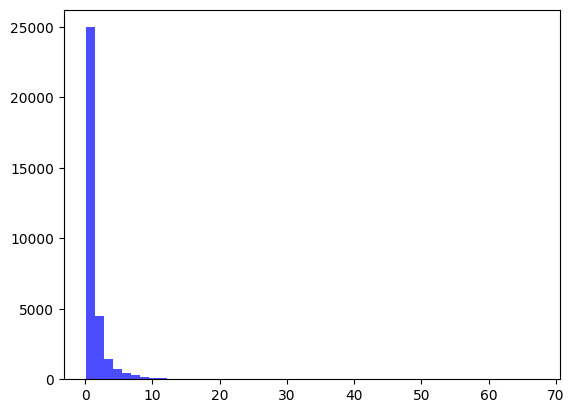

In [14]:
import matplotlib.pyplot as plt

plt.hist(df_pagerank_genes["score"], bins=50, color='blue', alpha=0.7)

## Clustering
### Community Detection
Louvain algorithm

In [8]:
def run_louvain() -> pd.DataFrame:
    with driver.session() as session:
        query = """
        CALL gds.louvain.stream('gene_protein_graph')
        YIELD nodeId, communityId
        RETURN gds.util.asNode(nodeId).id AS node, 
               gds.util.asNode(nodeId).gene_name AS gene_name,
               communityId,
               gds.util.asNode(nodeId).delta_tpm AS delta_tpm,
               gds.util.asNode(nodeId).cancer_active AS cancer_active
        ORDER BY communityId
        """
    
        result = session.run(query)
        
        df_results = pd.DataFrame([dict(record) for record in result], columns=result.keys())
        df_results = drop_protein_nodes(df_results)
    
        return df_results
    
df_louvain = run_louvain()

In [9]:
df_louvain

,node,gene_name,communityId,delta_tpm,cancer_active
40,ENSG00000163141,BNIPL,6459,0.187086,True
41,ENSG00000163632,C3orf49,6459,0.022181,False
42,ENSG00000180483,DEFB119,6459,0.198103,True
43,ENSG00000170486,KRT72,6459,0.131959,False
44,ENSG00000170423,KRT78,6459,0.263989,True
...,...,...,...,...,...
134584,ENSG00000070476,ZXDC,134589,0.018771,False
134585,ENSG00000232242,ZYG11AP1,134591,0.000026,False
134586,ENSG00000274572,ZYXP1,134593,0.000010,False
134591,ENSG00000074755,ZZEF1,134594,0.004983,False


In [10]:
# number of communities
print(f'Number of communities: {df_louvain["communityId"].nunique()}')
df_louvain["communityId"].nunique()

# number of communities with cancer active
ca_comm = df_louvain.where(df_louvain["cancer_active"] == True).dropna()["communityId"]
print(f'Number of communities with cancer active: {ca_comm.nunique()}')

Number of communities: 24167
Number of communities with cancer active: 799


In [11]:
# Dataframe only with communities that have cancer active nodes
df_louvain_ca = df_louvain.where(df_louvain["communityId"].isin(ca_comm)).dropna()

# group by communityId and count the number of cancer active nodes and the total number of nodes
df_louvain_ca_agg = df_louvain_ca.groupby("communityId").agg({"cancer_active": "sum", "node": "count"}).sort_values("cancer_active", ascending=False)
df_louvain_ca_agg = df_louvain_ca_agg.where(df_louvain_ca_agg["node"] > 1).dropna()
df_louvain_ca_agg["ratio"] = df_louvain_ca_agg["cancer_active"] / df_louvain_ca_agg["node"]

print("Communities with cancer active nodes:")
df_louvain_ca_agg

Communites with cancer active nodes:


,cancer_active,node,ratio
communityId,,,
12319.0,315,1922.0,0.163892
78668.0,118,551.0,0.214156
70573.0,90,1952.0,0.046107
99577.0,87,1063.0,0.081844
49359.0,82,1705.0,0.048094
19475.0,65,968.0,0.067149
16914.0,17,528.0,0.032197
6459.0,6,15.0,0.4


In [12]:
# TODO And now?

### KNN

In [ ]:
def run_knn() -> pd.DataFrame:
    with driver.session() as session:
        query = """
        CALL gds.knn.stream('gene_protein_graph')
        YIELD nodeId, otherNodeId, weight
        RETURN gds.util.asNode(nodeId).id AS node, 
               gds.util.asNode(nodeId).gene_name AS gene_name,
               gds.util.asNode(otherNodeId).id AS other_node,
               gds.util.asNode(otherNodeId).gene_name AS other_gene_name,
               weight
        """
        
        query = """
        CALL gds.louvain.stream('gene_protein_graph')
        YIELD nodeId, communityId
        RETURN gds.util.asNode(nodeId).id AS node, 
               gds.util.asNode(nodeId).gene_name AS gene_name,
               communityId,
               gds.util.asNode(nodeId).delta_tpm AS delta_tpm,
               gds.util.asNode(nodeId).cancer_active AS cancer_active
        ORDER BY communityId
        """
    
        result = session.run(query)
    
        return df_knn
    
df_knn = run_knn()